In [1]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from sklearn.datasets import fetch_20newsgroups

import nltk, string, itertools, time
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from scipy.optimize import linear_sum_assignment
from umap import UMAP

In [2]:
# Custom stop words
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(stop_words_skt))

In [3]:
def plot_contingency_table_20(cm, title='Contingency Table', cmap=plt.cm.YlOrBr):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    tick_marks = np.arange(20)
    number_labels = [x for x in range(1,21)]
    plt.xticks(tick_marks, number_labels)
    plt.yticks(tick_marks, number_labels)
    
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    plt.gcf().set_size_inches(10.0,10.0)
    plt.show()

In [4]:
def k_means_clustering(training_data,
                       target_labels,
                       title='Contingency Matrix',
                       n_clusters=20,
                       random_state=0,
                       max_iter=1000,
                       n_init=30):
    start = time.time()
    km = KMeans(n_clusters=n_clusters,random_state=random_state,max_iter=max_iter,n_init=n_init)
    km.fit(training_data)
    print("Finished clustering in %f seconds" % (time.time()-start))

    cm = contingency_matrix(target_labels, km.labels_)
    # reorder to maximize along diagonal
    rows, cols = linear_sum_assignment(cm, maximize=True)
    new_cm = cm[rows[:,np.newaxis], cols]
    
    print("Show Contingency Matrix:")
    plot_contingency_table_20(new_cm, title=title)
    
    print("Report 5 Measures for K-Means Clustering")
    
    homogeneity = homogeneity_score(target_labels, km.labels_)
    completeness = completeness_score(target_labels, km.labels_)
    v_measure = v_measure_score(target_labels, km.labels_)
    adjusted_rand_index = adjusted_rand_score(target_labels, km.labels_)
    adjusted_mutual_info = adjusted_mutual_info_score(target_labels, km.labels_)

    print("Homogeneity Score: %f" % homogeneity)
    print("Completeness Score: %f" % completeness)
    print("V-Measure Score: %f" % v_measure)
    print("Adjusted Rand Index: %f" % adjusted_rand_index)
    print("Adjusted Mutual Information: %f" % adjusted_mutual_info)
    
    results = {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }
    
    return results, km

In [5]:
def plot_histogram(title_name, ydata, x_labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300'], 
                   height=range(1,10),xtickangle=0):
    plt.gcf().clear()
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.25 for i in height])
    ax.set_xticklabels(x_labels, fontsize = 12)
    
    rects = plt.bar([i for i in height], ydata, 0.5, align='edge', alpha = 0.8)
    plt.xlabel('Number of Principal Components r', fontsize = 14)
    plt.ylabel('Measure Score', fontsize = 14)
    plt.title(title_name, fontsize = 18)
    plt.axis([0.5,len(x_labels)+1,0,1])
    
    plt.xticks(rotation=xtickangle)
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
    
    plt.show()

In [6]:
def svd_dimension_reduction(training_data, n_components=20, random_state=0):
    start = time.time()
    svd = TruncatedSVD(n_components=n_components, random_state=random_state)
    svd_dataset = svd.fit_transform(training_data)
    print("NMF complete after %f seconds" % (time.time()-start))
    return svd_dataset, svd

In [7]:
def nmf_dimension_reduction(training_data, n_components=None, solver='cd', beta_loss='frobenius', max_iter=1000, random_state=0):
    start = time.time()
    nmf = NMF(n_components=n_components, solver=solver, init='nndsvda', beta_loss=beta_loss, max_iter=max_iter, random_state=random_state)
    nmf_dataset = nmf.fit_transform(training_data)
    print("NMF complete after %f seconds" % (time.time()-start))
    return nmf_dataset, nmf

In [8]:
def umap_dimension_reduction(training_data, n_components=20, metric='cosine', disconnection_distance=None, random_state=0):
    start = time.time()
    umap = UMAP(n_components=n_components, metric=metric, disconnection_distance=disconnection_distance, random_state=random_state)
    umap_dataset = umap.fit_transform(training_data)
    print("UMAP complete after %f seconds" % (time.time()-start))
    return umap_dataset, umap

In [9]:
#Question 9
dataset_20 = fetch_20newsgroups(subset='all',shuffle=True, remove=('headers', 'footers'), random_state=42)
tfidf_vect_20 = TfidfVectorizer(stop_words=combined_stopwords,min_df=3)
X_train_tfidf_20 = tfidf_vect_20.fit_transform(dataset_20.data) # making the tfidf matrix
print(X_train_tfidf_20.shape)

y_true_20 = dataset_20.target

(18846, 45338)


n_components: 1
NMF complete after 0.340010 seconds
Finished clustering in 0.921035 seconds
Show Contingency Matrix:


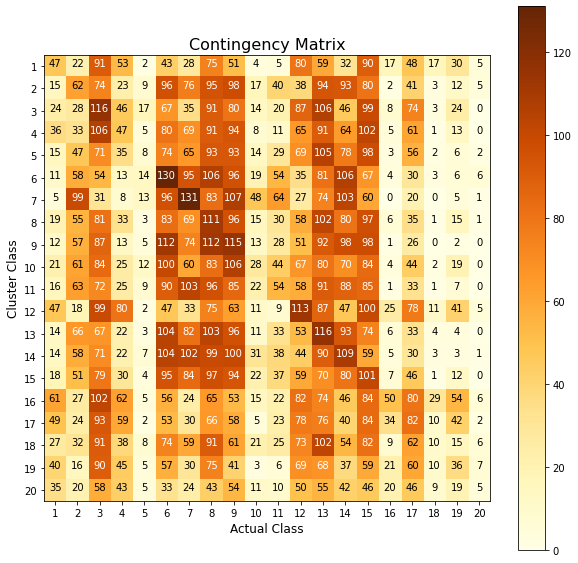

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.023846
Completeness Score: 0.025863
V-Measure Score: 0.024813
Adjusted Rand Index: 0.004854
Adjusted Mutual Information: 0.021505
n_components: 2
NMF complete after 0.282948 seconds
Finished clustering in 2.130908 seconds
Show Contingency Matrix:


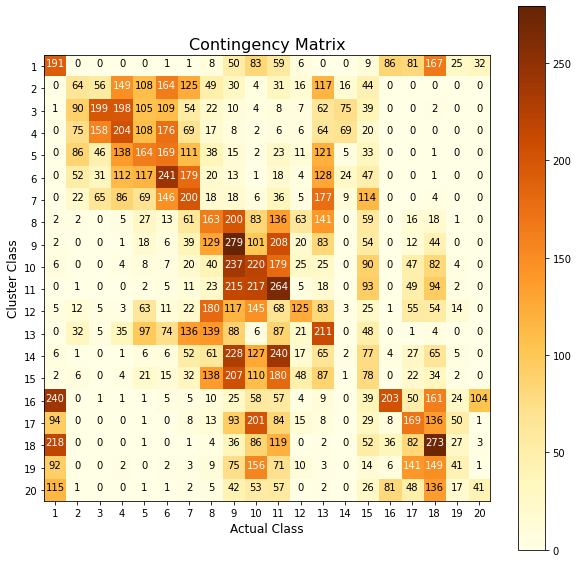

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.214361
Completeness Score: 0.227049
V-Measure Score: 0.220522
Adjusted Rand Index: 0.067026
Adjusted Mutual Information: 0.217927
n_components: 3
NMF complete after 0.311271 seconds
Finished clustering in 2.229111 seconds
Show Contingency Matrix:


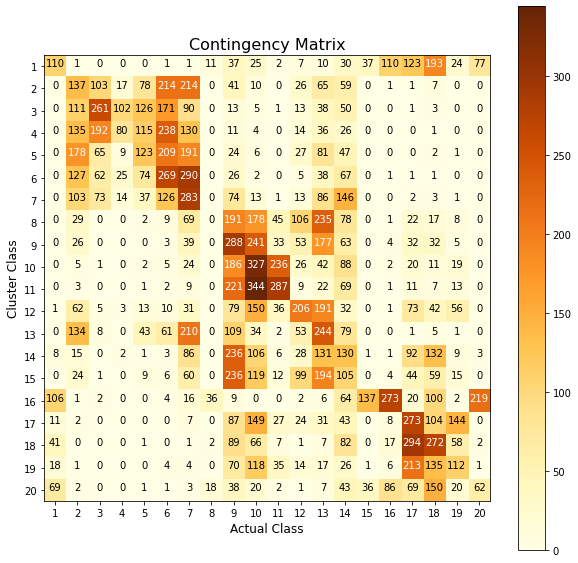

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.249399
Completeness Score: 0.267737
V-Measure Score: 0.258243
Adjusted Rand Index: 0.085790
Adjusted Mutual Information: 0.255749
n_components: 5
NMF complete after 0.380046 seconds
Finished clustering in 2.705387 seconds
Show Contingency Matrix:


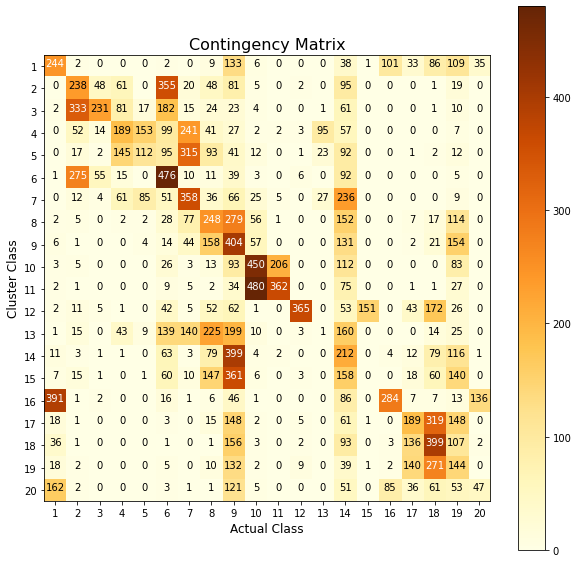

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.323658
Completeness Score: 0.352436
V-Measure Score: 0.337435
Adjusted Rand Index: 0.127469
Adjusted Mutual Information: 0.335196
n_components: 10
NMF complete after 0.469687 seconds
Finished clustering in 2.200041 seconds
Show Contingency Matrix:


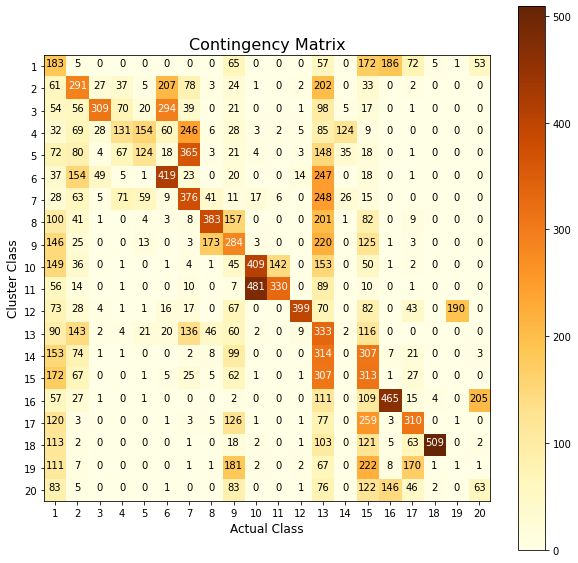

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.328387
Completeness Score: 0.360014
V-Measure Score: 0.343474
Adjusted Rand Index: 0.122593
Adjusted Mutual Information: 0.341251
n_components: 20
NMF complete after 0.769725 seconds
Finished clustering in 2.133773 seconds
Show Contingency Matrix:


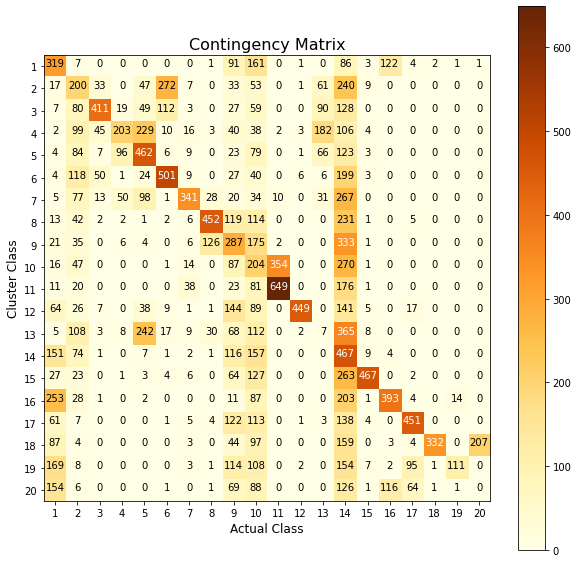

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.344179
Completeness Score: 0.384330
V-Measure Score: 0.363148
Adjusted Rand Index: 0.125723
Adjusted Mutual Information: 0.360971
n_components: 50
NMF complete after 1.747694 seconds
Finished clustering in 3.967933 seconds
Show Contingency Matrix:


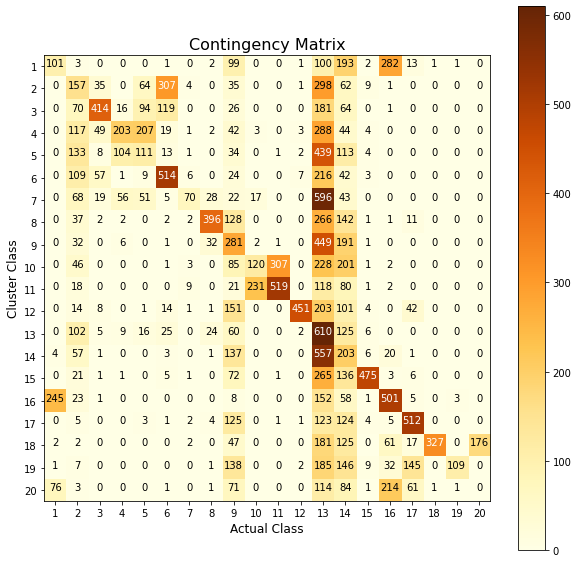

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.327755
Completeness Score: 0.391352
V-Measure Score: 0.356741
Adjusted Rand Index: 0.100818
Adjusted Mutual Information: 0.354466
n_components: 100
NMF complete after 3.225988 seconds
Finished clustering in 6.028929 seconds
Show Contingency Matrix:


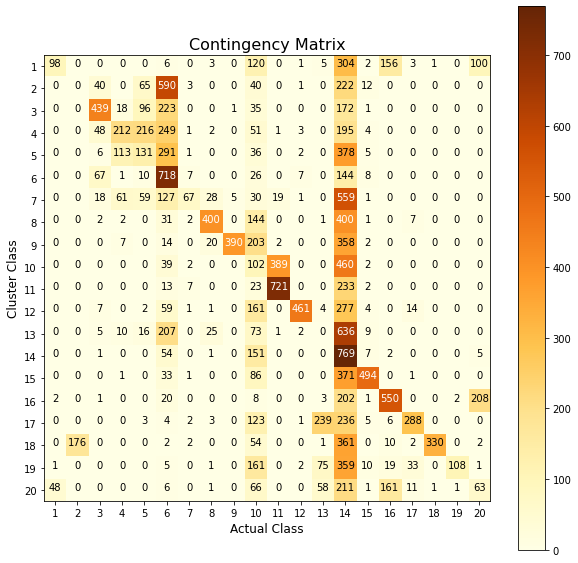

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.347359
Completeness Score: 0.450658
V-Measure Score: 0.392323
Adjusted Rand Index: 0.097621
Adjusted Mutual Information: 0.390087
n_components: 300
NMF complete after 9.455730 seconds
Finished clustering in 18.474019 seconds
Show Contingency Matrix:


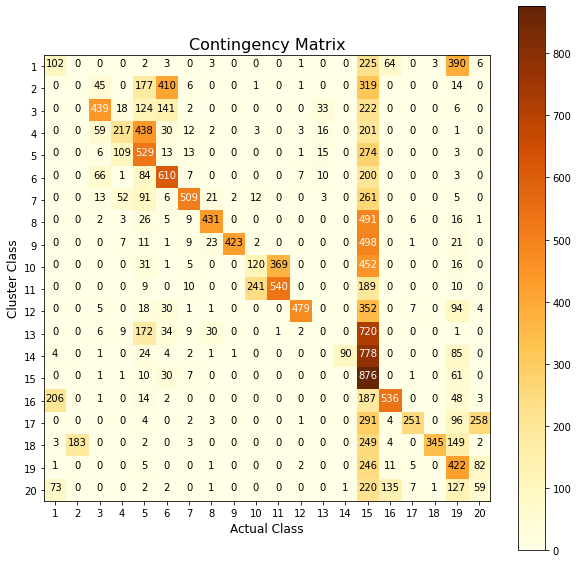

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.383471
Completeness Score: 0.494123
V-Measure Score: 0.431821
Adjusted Rand Index: 0.107822
Adjusted Mutual Information: 0.429736


In [10]:
# Question 9: SVD
svd_homogeneity_1ist = []
svd_completeness_1ist = []
svd_v_measure_1ist = []
svd_adjusted_rand_index_1ist = []
svd_adjusted_mutual_info_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    svd_dataset, svd = svd_dimension_reduction(X_train_tfidf_20, n_components = r, random_state=0)
    k_means, km = k_means_clustering(svd_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    svd_homogeneity_1ist.append(k_means['homogeneity'])
    svd_completeness_1ist.append(k_means['completeness'])
    svd_v_measure_1ist.append(k_means['v_measure'])
    svd_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])
    svd_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])

<Figure size 432x288 with 0 Axes>

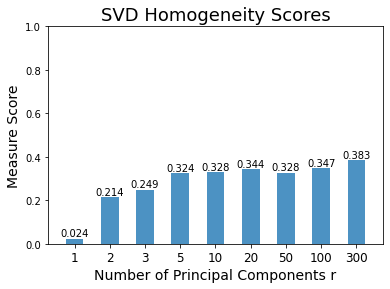

<Figure size 432x288 with 0 Axes>

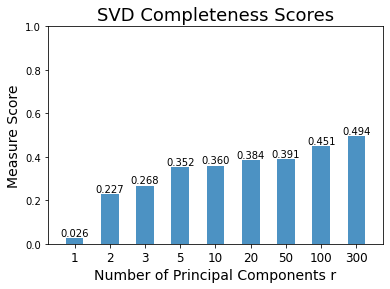

<Figure size 432x288 with 0 Axes>

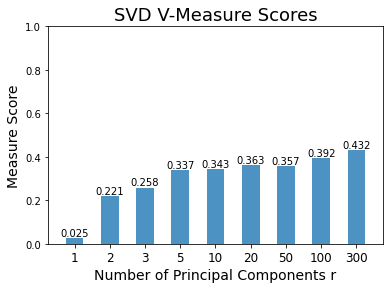

<Figure size 432x288 with 0 Axes>

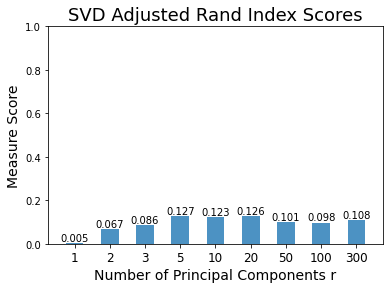

<Figure size 432x288 with 0 Axes>

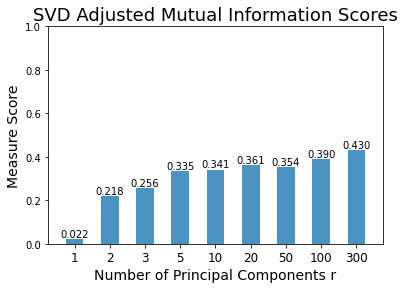

In [12]:
plot_histogram('SVD Homogeneity Scores', svd_homogeneity_1ist)
plot_histogram('SVD Completeness Scores', svd_completeness_1ist)
plot_histogram('SVD V-Measure Scores', svd_v_measure_1ist)
plot_histogram('SVD Adjusted Rand Index Scores', svd_adjusted_rand_index_1ist)
plot_histogram('SVD Adjusted Mutual Information Scores', svd_adjusted_mutual_info_1ist)

n_components: 1
NMF complete after 0.568271 seconds
Finished clustering in 1.038504 seconds
Show Contingency Matrix:


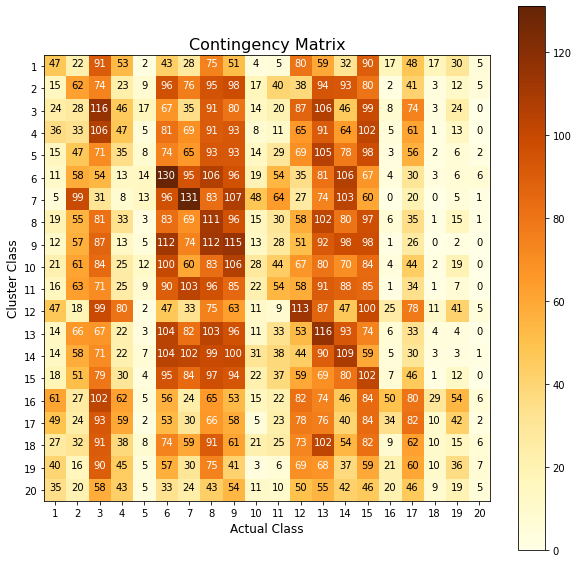

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.023846
Completeness Score: 0.025863
V-Measure Score: 0.024814
Adjusted Rand Index: 0.004856
Adjusted Mutual Information: 0.021506
n_components: 2
NMF complete after 0.647344 seconds
Finished clustering in 1.781159 seconds
Show Contingency Matrix:


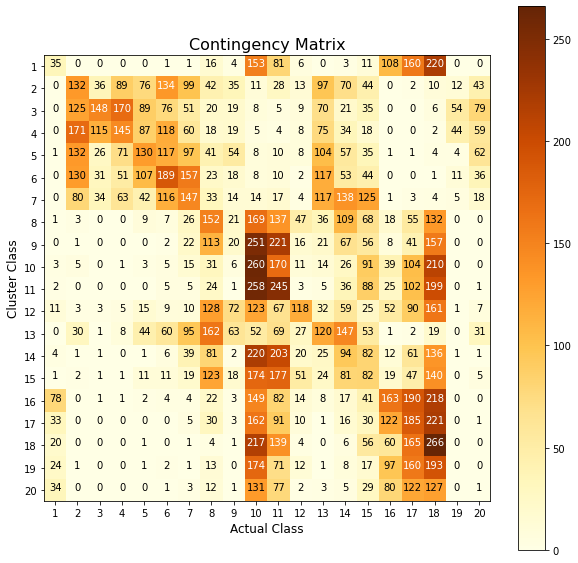

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.180591
Completeness Score: 0.194892
V-Measure Score: 0.187469
Adjusted Rand Index: 0.049849
Adjusted Mutual Information: 0.184738
n_components: 3
NMF complete after 0.726995 seconds
Finished clustering in 1.769476 seconds
Show Contingency Matrix:


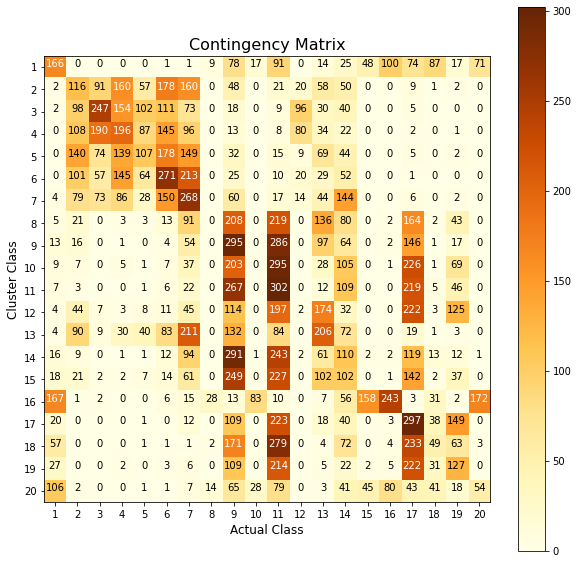

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.218448
Completeness Score: 0.243881
V-Measure Score: 0.230464
Adjusted Rand Index: 0.064754
Adjusted Mutual Information: 0.227820
n_components: 5
NMF complete after 0.941452 seconds
Finished clustering in 2.012130 seconds
Show Contingency Matrix:


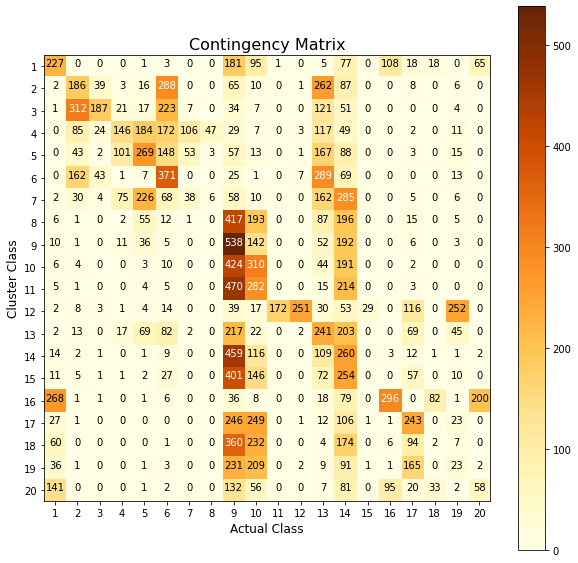

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.255040
Completeness Score: 0.308949
V-Measure Score: 0.279418
Adjusted Rand Index: 0.077474
Adjusted Mutual Information: 0.276822
n_components: 10
NMF complete after 1.985261 seconds
Finished clustering in 1.578042 seconds
Show Contingency Matrix:


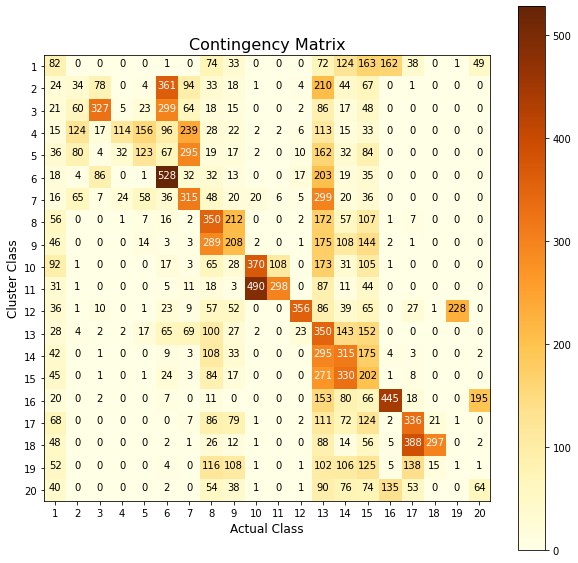

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.299800
Completeness Score: 0.328841
V-Measure Score: 0.313650
Adjusted Rand Index: 0.113098
Adjusted Mutual Information: 0.311325
n_components: 20
NMF complete after 4.251372 seconds
Finished clustering in 2.085549 seconds
Show Contingency Matrix:


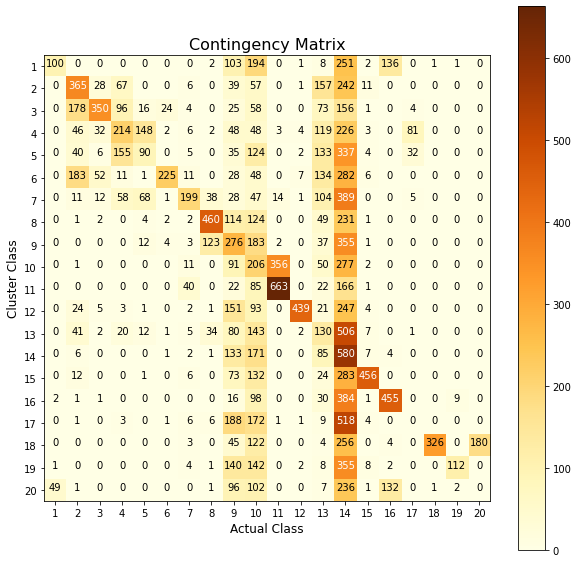

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.283461
Completeness Score: 0.354444
V-Measure Score: 0.315003
Adjusted Rand Index: 0.070218
Adjusted Mutual Information: 0.312527
n_components: 50
NMF complete after 14.012936 seconds
Finished clustering in 3.383869 seconds
Show Contingency Matrix:


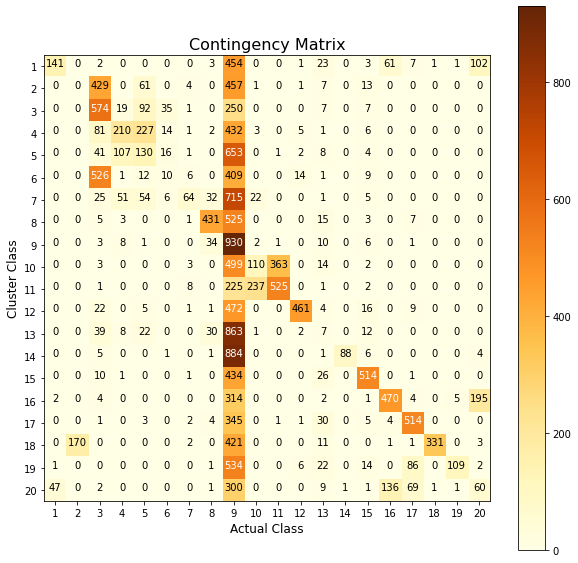

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.312888
Completeness Score: 0.488306
V-Measure Score: 0.381393
Adjusted Rand Index: 0.055781
Adjusted Mutual Information: 0.378922
n_components: 100
NMF complete after 31.732789 seconds
Finished clustering in 5.881744 seconds
Show Contingency Matrix:


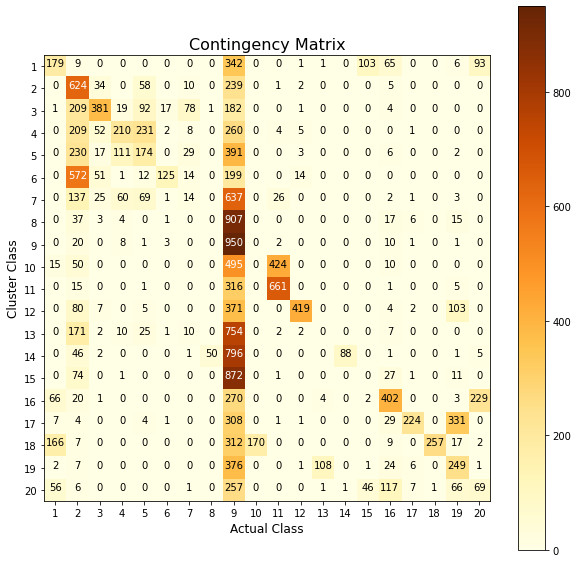

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.291678
Completeness Score: 0.441442
V-Measure Score: 0.351263
Adjusted Rand Index: 0.065192
Adjusted Mutual Information: 0.348696
n_components: 300
NMF complete after 168.021709 seconds
Finished clustering in 13.188562 seconds
Show Contingency Matrix:


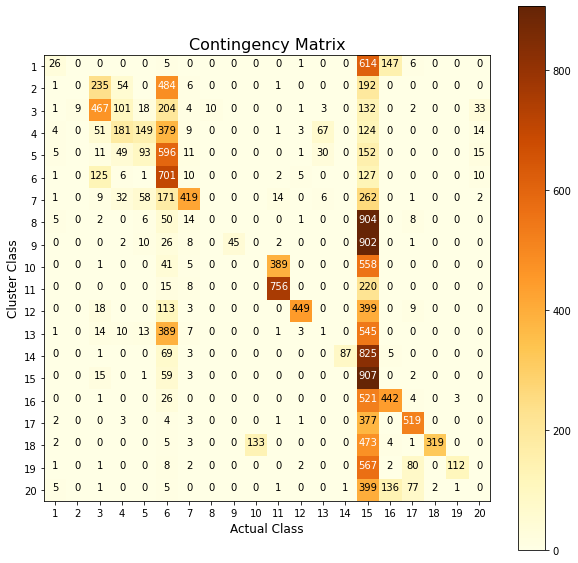

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.299455
Completeness Score: 0.488490
V-Measure Score: 0.371297
Adjusted Rand Index: 0.077279
Adjusted Mutual Information: 0.368713


In [13]:
# Question 9: NMF (Frobenius)
nmf_homogeneity_1ist = []
nmf_completeness_1ist = []
nmf_v_measure_1ist = []
nmf_adjusted_rand_index_1ist = []
nmf_adjusted_mutual_info_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    nmf_dataset, nmf = nmf_dimension_reduction(X_train_tfidf_20, n_components = r, solver='mu', beta_loss='frobenius', max_iter=1000, random_state=0)
    k_means, km = k_means_clustering(nmf_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    nmf_homogeneity_1ist.append(k_means['homogeneity'])
    nmf_completeness_1ist.append(k_means['completeness'])
    nmf_v_measure_1ist.append(k_means['v_measure'])
    nmf_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])
    nmf_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])

<Figure size 432x288 with 0 Axes>

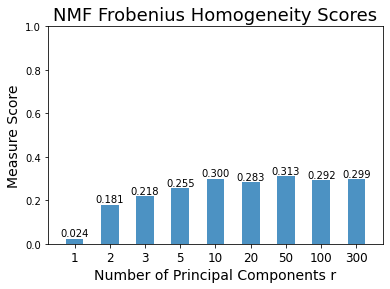

<Figure size 432x288 with 0 Axes>

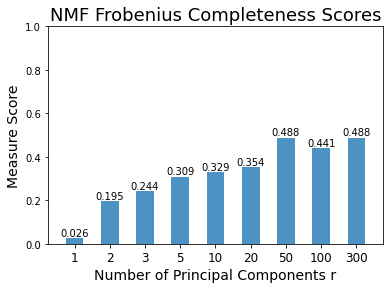

<Figure size 432x288 with 0 Axes>

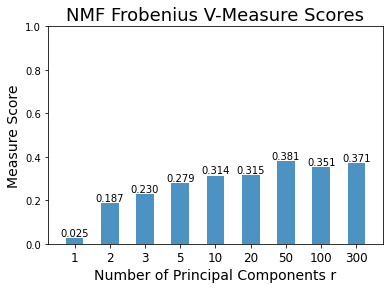

<Figure size 432x288 with 0 Axes>

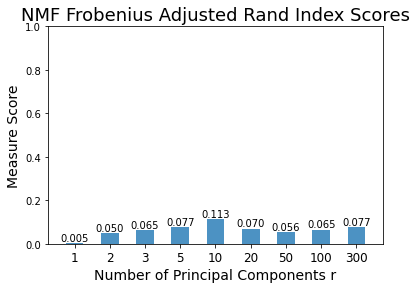

<Figure size 432x288 with 0 Axes>

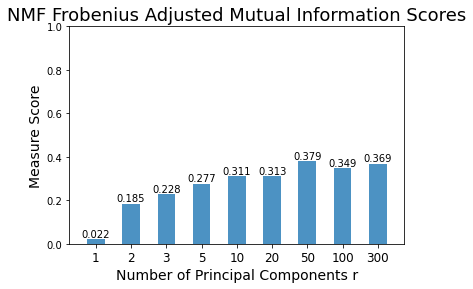

In [14]:
plot_histogram('NMF Frobenius Homogeneity Scores', nmf_homogeneity_1ist)
plot_histogram('NMF Frobenius Completeness Scores', nmf_completeness_1ist)
plot_histogram('NMF Frobenius V-Measure Scores', nmf_v_measure_1ist)
plot_histogram('NMF Frobenius Adjusted Rand Index Scores', nmf_adjusted_rand_index_1ist)
plot_histogram('NMF Frobenius Adjusted Mutual Information Scores', nmf_adjusted_mutual_info_1ist)

n_components: 1
NMF complete after 2.527615 seconds
Finished clustering in 0.979674 seconds
Show Contingency Matrix:


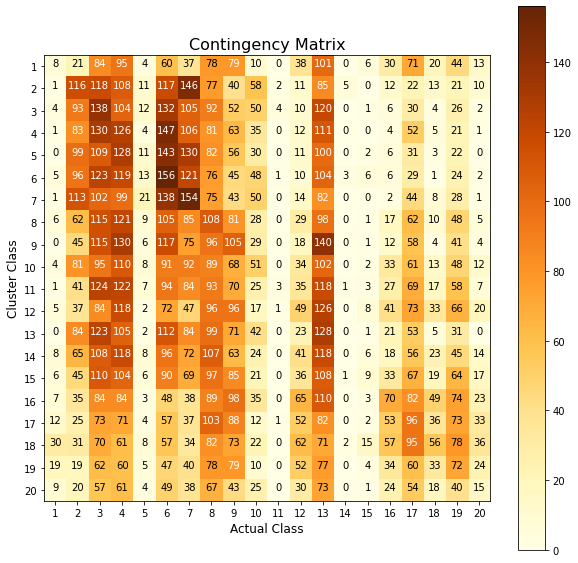

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.025393
Completeness Score: 0.028832
V-Measure Score: 0.027003
Adjusted Rand Index: 0.005504
Adjusted Mutual Information: 0.023613
n_components: 2
NMF complete after 11.194644 seconds
Finished clustering in 1.378540 seconds
Show Contingency Matrix:


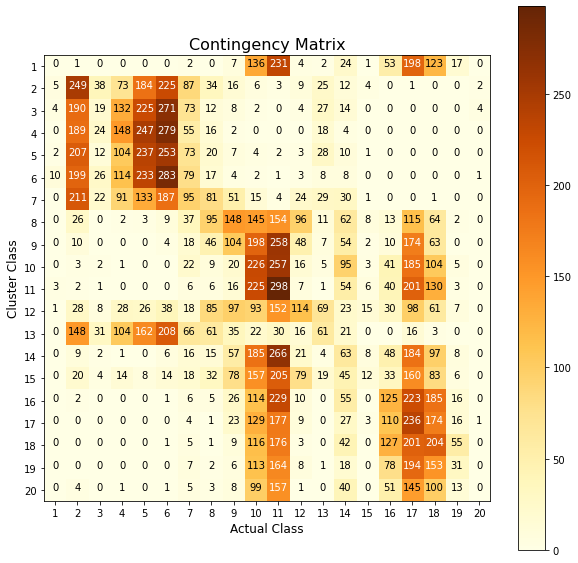

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.197520
Completeness Score: 0.225177
V-Measure Score: 0.210444
Adjusted Rand Index: 0.061763
Adjusted Mutual Information: 0.207692
n_components: 3
NMF complete after 21.438548 seconds
Finished clustering in 1.497382 seconds
Show Contingency Matrix:


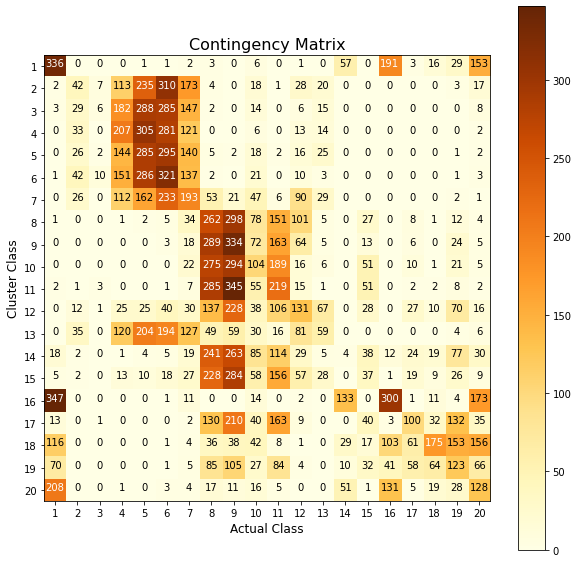

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.278874
Completeness Score: 0.305391
V-Measure Score: 0.291531
Adjusted Rand Index: 0.100421
Adjusted Mutual Information: 0.289114
n_components: 5
NMF complete after 22.043420 seconds
Finished clustering in 1.727406 seconds
Show Contingency Matrix:


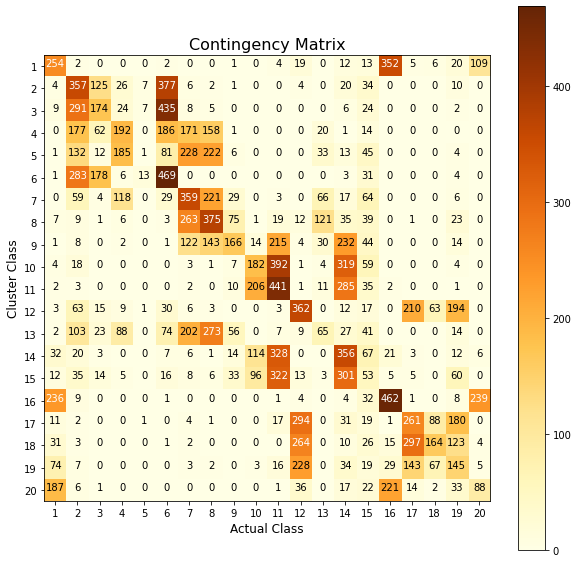

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.387035
Completeness Score: 0.408639
V-Measure Score: 0.397544
Adjusted Rand Index: 0.168810
Adjusted Mutual Information: 0.395528
n_components: 10
NMF complete after 36.279138 seconds
Finished clustering in 1.527573 seconds
Show Contingency Matrix:


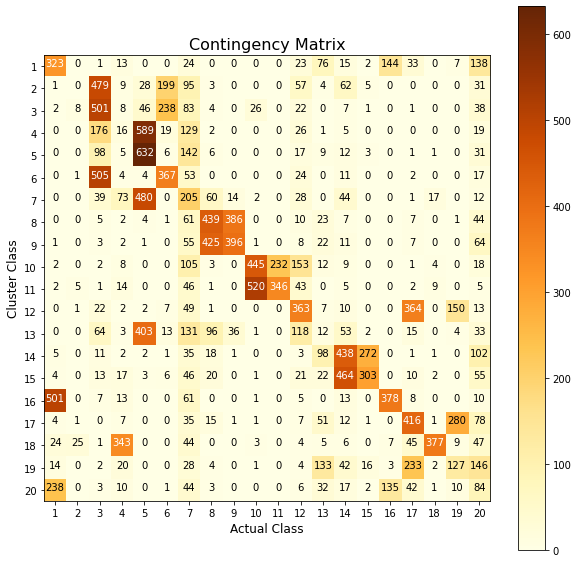

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.461592
Completeness Score: 0.483712
V-Measure Score: 0.472393
Adjusted Rand Index: 0.245988
Adjusted Mutual Information: 0.470637
n_components: 20
NMF complete after 59.756473 seconds
Finished clustering in 1.492371 seconds
Show Contingency Matrix:


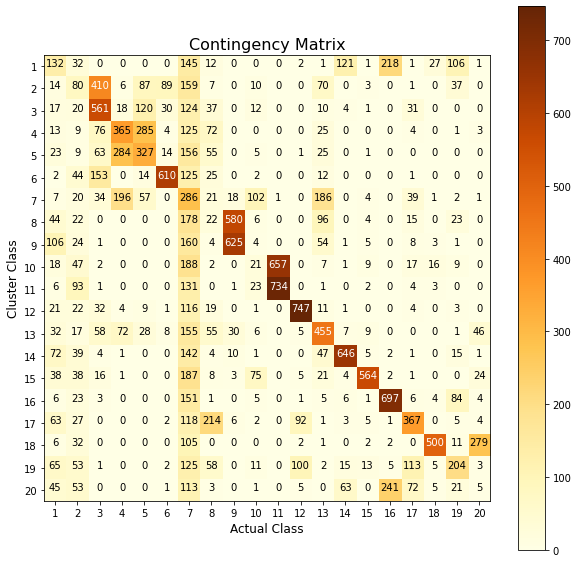

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.462230
Completeness Score: 0.484221
V-Measure Score: 0.472970
Adjusted Rand Index: 0.264474
Adjusted Mutual Information: 0.471228
n_components: 50
NMF complete after 128.082155 seconds
Finished clustering in 2.323344 seconds
Show Contingency Matrix:


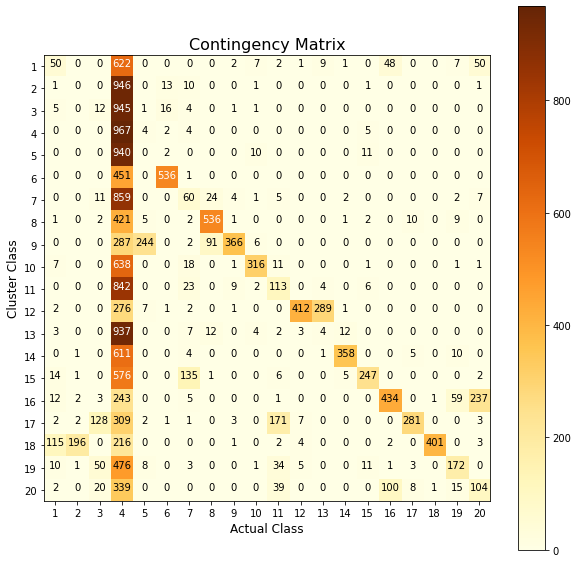

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.307625
Completeness Score: 0.533807
V-Measure Score: 0.390317
Adjusted Rand Index: 0.043475
Adjusted Mutual Information: 0.387800
n_components: 100
NMF complete after 1007.823989 seconds
Finished clustering in 11.152116 seconds
Show Contingency Matrix:


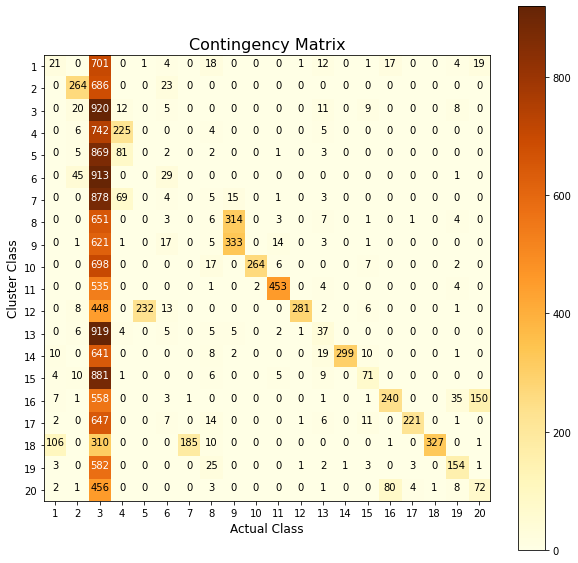

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.217950
Completeness Score: 0.476393
V-Measure Score: 0.299074
Adjusted Rand Index: 0.016701
Adjusted Mutual Information: 0.295920
n_components: 300
NMF complete after 1204.898174 seconds
Finished clustering in 16.841672 seconds
Show Contingency Matrix:


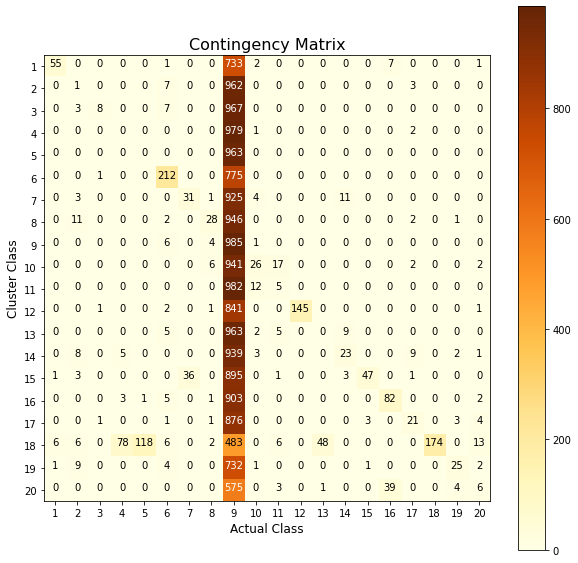

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.064358
Completeness Score: 0.394907
V-Measure Score: 0.110678
Adjusted Rand Index: 0.002443
Adjusted Mutual Information: 0.105277


In [15]:
# Question 10: NMF 'Kullback-Leibler'
nmf_kl_homogeneity_1ist = []
nmf_kl_completeness_1ist = []
nmf_kl_v_measure_1ist = []
nmf_kl_adjusted_rand_index_1ist = []
nmf_kl_adjusted_mutual_info_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    nmf_dataset, nmf = nmf_dimension_reduction(X_train_tfidf_20, n_components = r, solver='mu', beta_loss='kullback-leibler', max_iter=1000, random_state=0)
    k_means, km = k_means_clustering(nmf_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    nmf_kl_homogeneity_1ist.append(k_means['homogeneity'])
    nmf_kl_completeness_1ist.append(k_means['completeness'])
    nmf_kl_v_measure_1ist.append(k_means['v_measure'])
    nmf_kl_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])
    nmf_kl_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])

<Figure size 432x288 with 0 Axes>

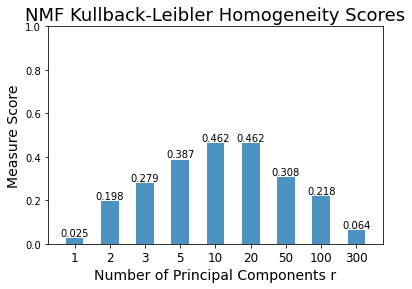

<Figure size 432x288 with 0 Axes>

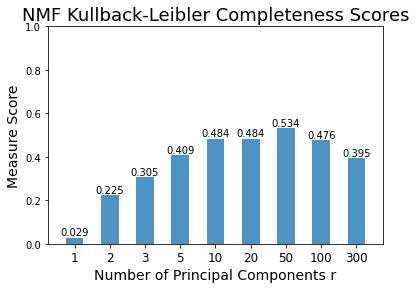

<Figure size 432x288 with 0 Axes>

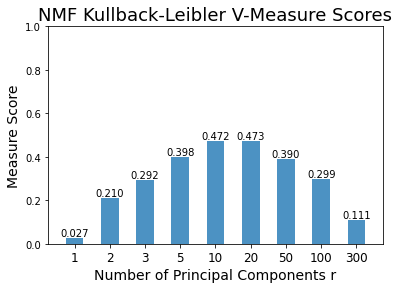

<Figure size 432x288 with 0 Axes>

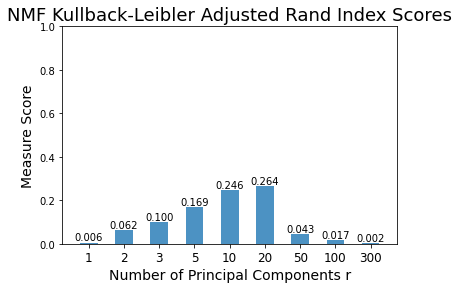

<Figure size 432x288 with 0 Axes>

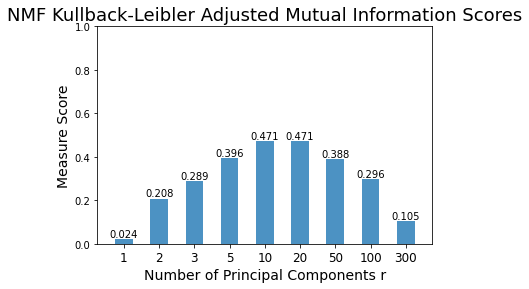

In [16]:
plot_histogram('NMF Kullback-Leibler Homogeneity Scores', nmf_kl_homogeneity_1ist)
plot_histogram('NMF Kullback-Leibler Completeness Scores', nmf_kl_completeness_1ist)
plot_histogram('NMF Kullback-Leibler V-Measure Scores', nmf_kl_v_measure_1ist)
plot_histogram('NMF Kullback-Leibler Adjusted Rand Index Scores', nmf_kl_adjusted_rand_index_1ist)
plot_histogram('NMF Kullback-Leibler Adjusted Mutual Information Scores', nmf_kl_adjusted_mutual_info_1ist)

n_components: 1
UMAP complete after 87.994572 seconds
Finished clustering in 1.727634 seconds
Show Contingency Matrix:


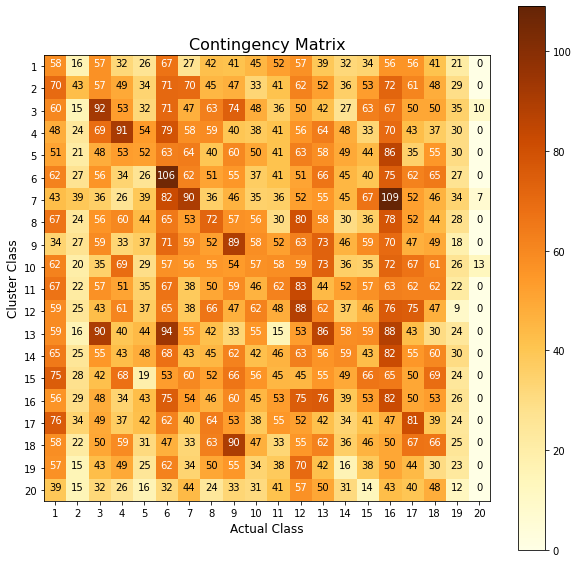

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.009374
Completeness Score: 0.009600
V-Measure Score: 0.009486
Adjusted Rand Index: 0.001743
Adjusted Mutual Information: 0.006224
n_components: 2
UMAP complete after 66.854111 seconds
Finished clustering in 3.021303 seconds
Show Contingency Matrix:


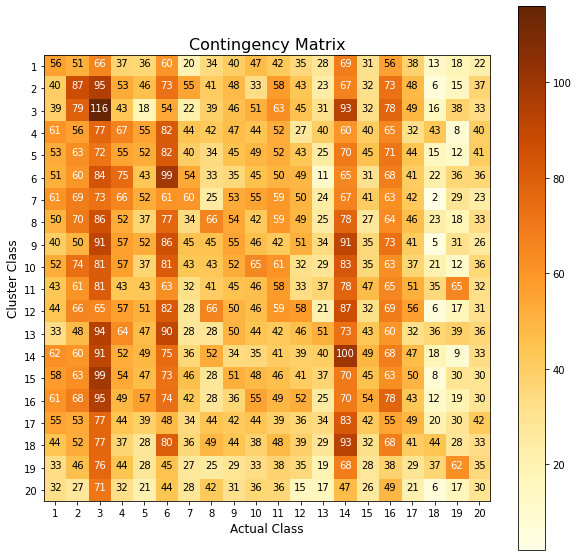

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.008099
Completeness Score: 0.008244
V-Measure Score: 0.008171
Adjusted Rand Index: 0.001066
Adjusted Mutual Information: 0.004941
n_components: 3
UMAP complete after 71.095472 seconds
Finished clustering in 3.352133 seconds
Show Contingency Matrix:


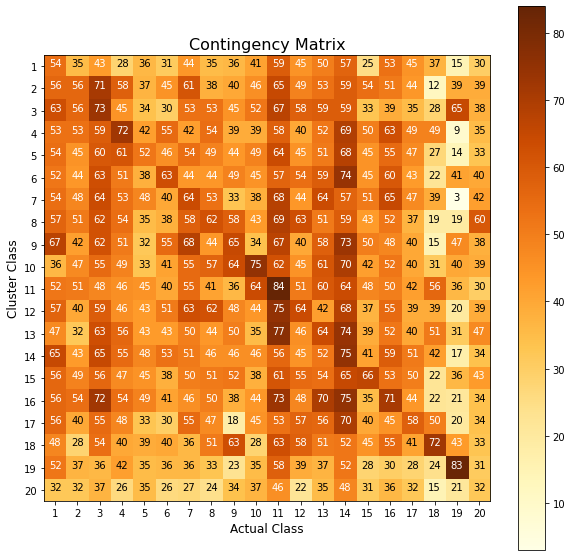

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.007013
Completeness Score: 0.007040
V-Measure Score: 0.007027
Adjusted Rand Index: 0.000901
Adjusted Mutual Information: 0.003816
n_components: 5
UMAP complete after 78.229150 seconds
Finished clustering in 6.624746 seconds
Show Contingency Matrix:


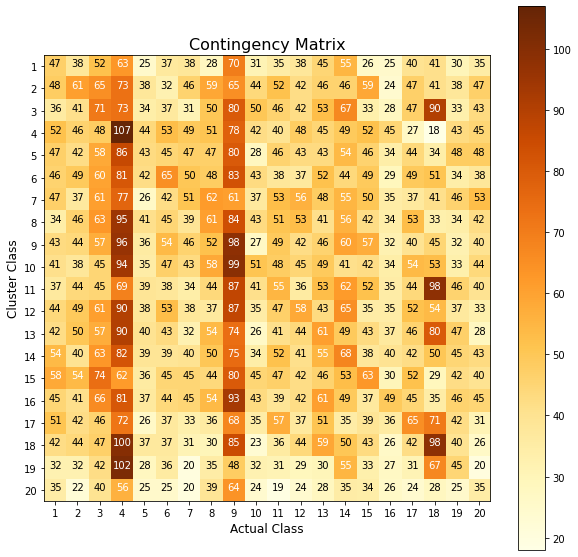

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005709
Completeness Score: 0.005758
V-Measure Score: 0.005733
Adjusted Rand Index: 0.000847
Adjusted Mutual Information: 0.002511
n_components: 10
UMAP complete after 90.890539 seconds
Finished clustering in 4.531799 seconds
Show Contingency Matrix:


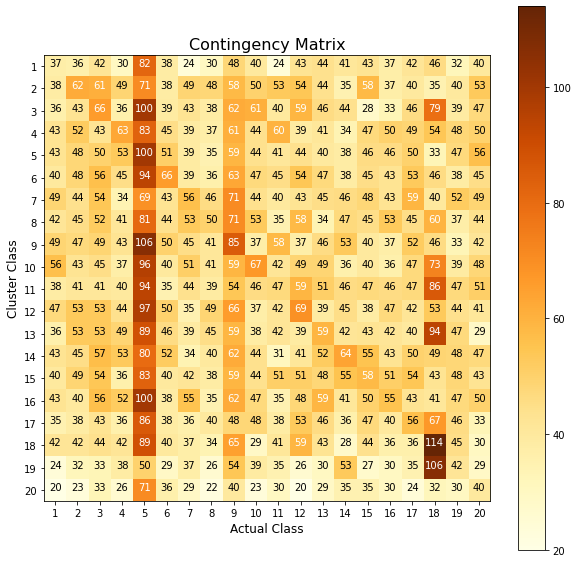

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005266
Completeness Score: 0.005294
V-Measure Score: 0.005280
Adjusted Rand Index: 0.000782
Adjusted Mutual Information: 0.002062
n_components: 20
UMAP complete after 116.642073 seconds
Finished clustering in 5.708520 seconds
Show Contingency Matrix:


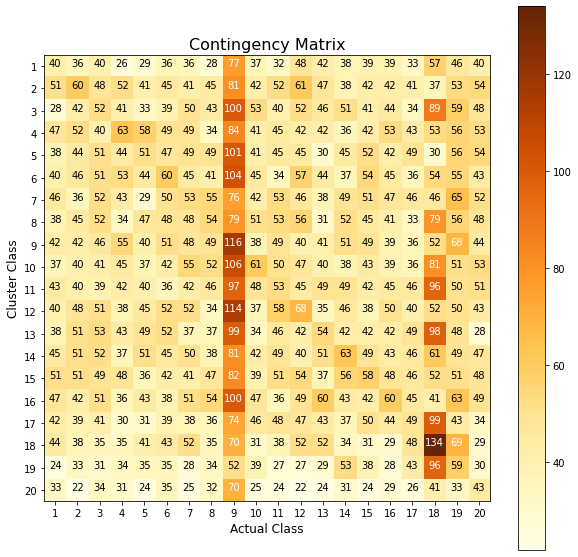

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005486
Completeness Score: 0.005519
V-Measure Score: 0.005502
Adjusted Rand Index: 0.000970
Adjusted Mutual Information: 0.002284
n_components: 50
UMAP complete after 167.637359 seconds
Finished clustering in 8.041191 seconds
Show Contingency Matrix:


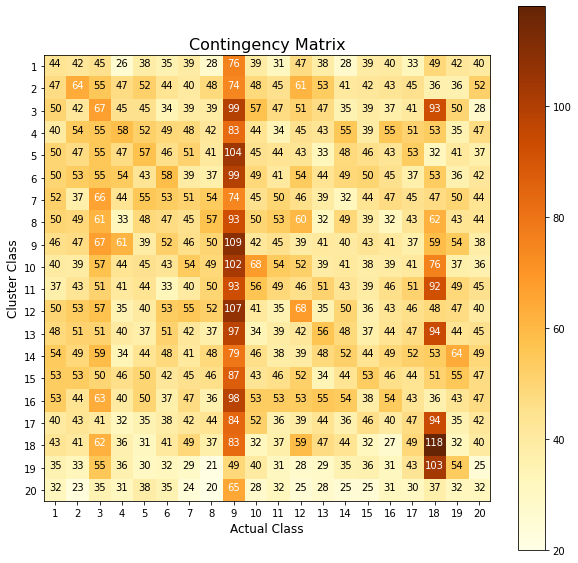

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005135
Completeness Score: 0.005164
V-Measure Score: 0.005149
Adjusted Rand Index: 0.000797
Adjusted Mutual Information: 0.001930
n_components: 100
UMAP complete after 260.681223 seconds
Finished clustering in 12.772494 seconds
Show Contingency Matrix:


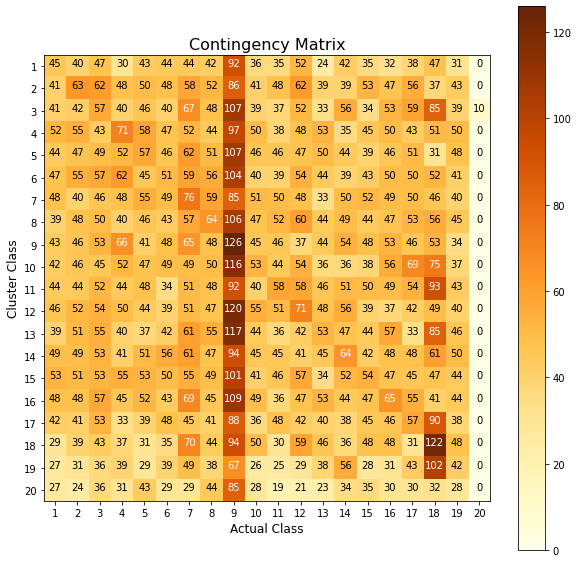

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005520
Completeness Score: 0.005654
V-Measure Score: 0.005586
Adjusted Rand Index: 0.000751
Adjusted Mutual Information: 0.002335
n_components: 300
UMAP complete after 554.761907 seconds
Finished clustering in 15.727389 seconds
Show Contingency Matrix:


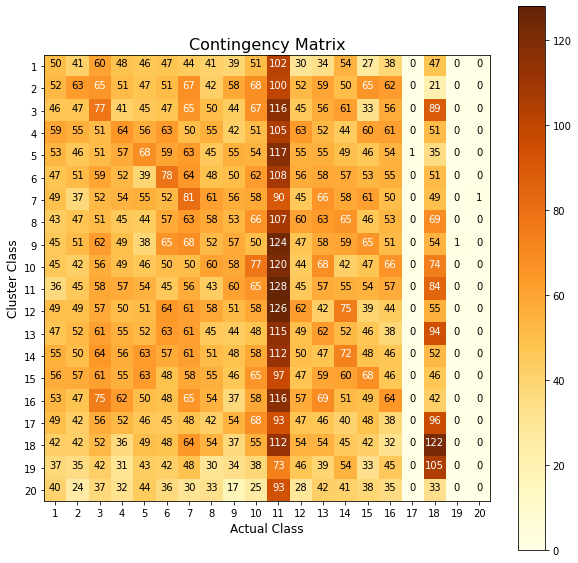

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.005256
Completeness Score: 0.005596
V-Measure Score: 0.005420
Adjusted Rand Index: 0.000834
Adjusted Mutual Information: 0.002472


In [17]:
# Question 11: UMAP 'Euclidean'
umap_euclidean_homogeneity_1ist = []
umap_euclidean_completeness_1ist = []
umap_euclidean_v_measure_1ist = []
umap_euclidean_adjusted_rand_index_1ist = []
umap_euclidean_adjusted_mutual_info_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    umap_dataset, umap = umap_dimension_reduction(X_train_tfidf_20, n_components = r, metric='euclidean', disconnection_distance=2, random_state=0)
    k_means, km = k_means_clustering(umap_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    umap_euclidean_homogeneity_1ist.append(k_means['homogeneity'])
    umap_euclidean_completeness_1ist.append(k_means['completeness'])
    umap_euclidean_v_measure_1ist.append(k_means['v_measure'])
    umap_euclidean_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])
    umap_euclidean_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])

<Figure size 432x288 with 0 Axes>

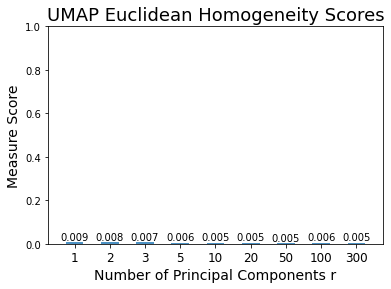

<Figure size 432x288 with 0 Axes>

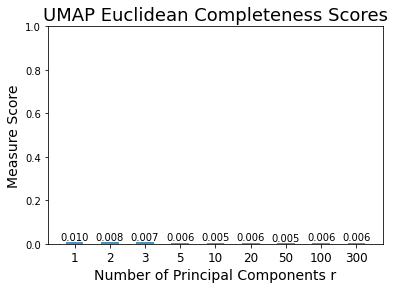

<Figure size 432x288 with 0 Axes>

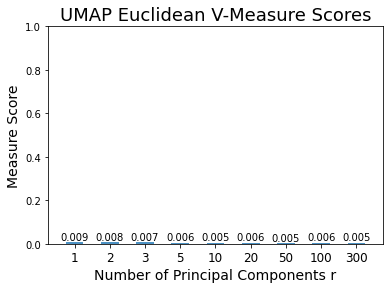

<Figure size 432x288 with 0 Axes>

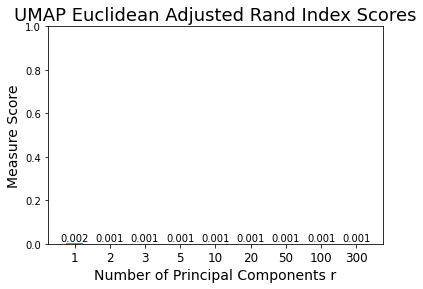

<Figure size 432x288 with 0 Axes>

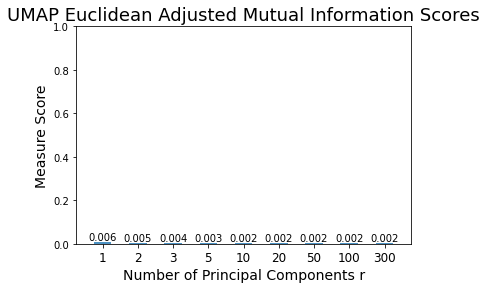

In [18]:
plot_histogram('UMAP Euclidean Homogeneity Scores', umap_euclidean_homogeneity_1ist)
plot_histogram('UMAP Euclidean Completeness Scores', umap_euclidean_completeness_1ist)
plot_histogram('UMAP Euclidean V-Measure Scores', umap_euclidean_v_measure_1ist)
plot_histogram('UMAP Euclidean Adjusted Rand Index Scores', umap_euclidean_adjusted_rand_index_1ist)
plot_histogram('UMAP Euclidean Adjusted Mutual Information Scores', umap_euclidean_adjusted_mutual_info_1ist)

n_components: 1
UMAP complete after 89.939688 seconds
Finished clustering in 2.099482 seconds
Show Contingency Matrix:


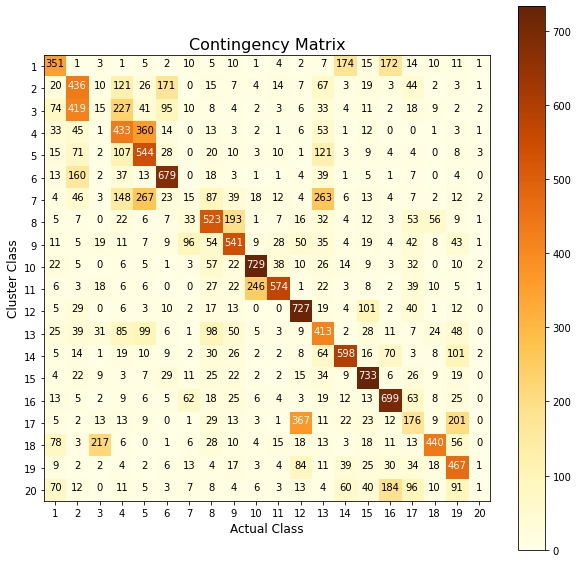

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.430314
Completeness Score: 0.445549
V-Measure Score: 0.437799
Adjusted Rand Index: 0.297585
Adjusted Mutual Information: 0.435937
n_components: 2
UMAP complete after 76.500616 seconds
Finished clustering in 2.514227 seconds
Show Contingency Matrix:


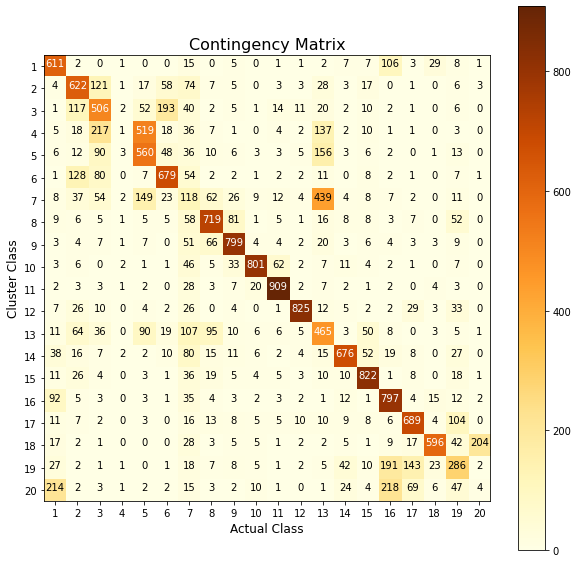

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.562357
Completeness Score: 0.578616
V-Measure Score: 0.570371
Adjusted Rand Index: 0.446195
Adjusted Mutual Information: 0.568953
n_components: 3
UMAP complete after 76.314092 seconds
Finished clustering in 6.438821 seconds
Show Contingency Matrix:


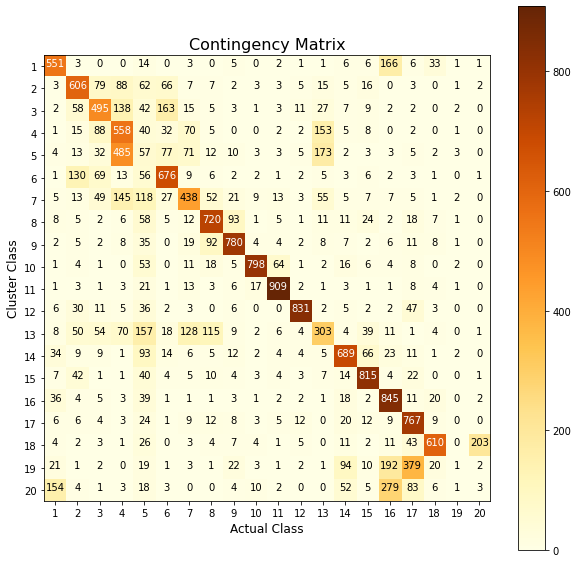

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.558873
Completeness Score: 0.576123
V-Measure Score: 0.567367
Adjusted Rand Index: 0.442089
Adjusted Mutual Information: 0.565938
n_components: 5
UMAP complete after 82.255876 seconds
Finished clustering in 4.746758 seconds
Show Contingency Matrix:


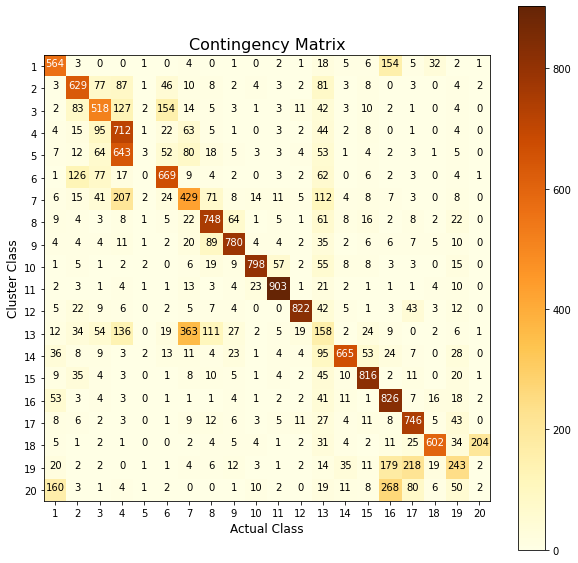

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.565223
Completeness Score: 0.585504
V-Measure Score: 0.575185
Adjusted Rand Index: 0.448447
Adjusted Mutual Information: 0.573778
n_components: 10
UMAP complete after 91.205341 seconds
Finished clustering in 3.592872 seconds
Show Contingency Matrix:


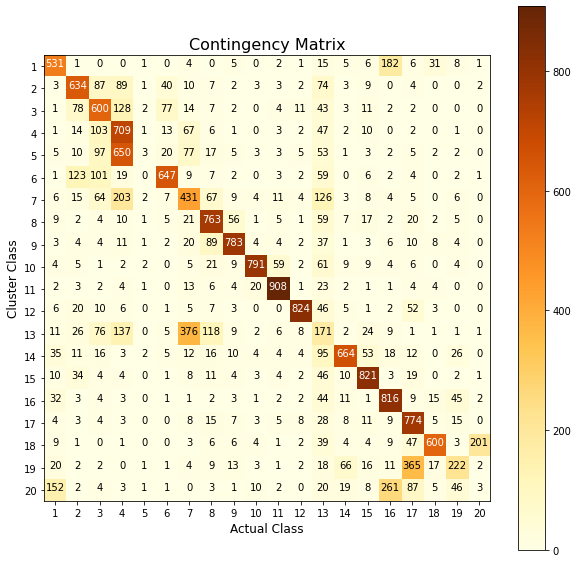

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.572315
Completeness Score: 0.594859
V-Measure Score: 0.583369
Adjusted Rand Index: 0.452950
Adjusted Mutual Information: 0.581987
n_components: 20
UMAP complete after 58.664028 seconds
Finished clustering in 2.892058 seconds
Show Contingency Matrix:


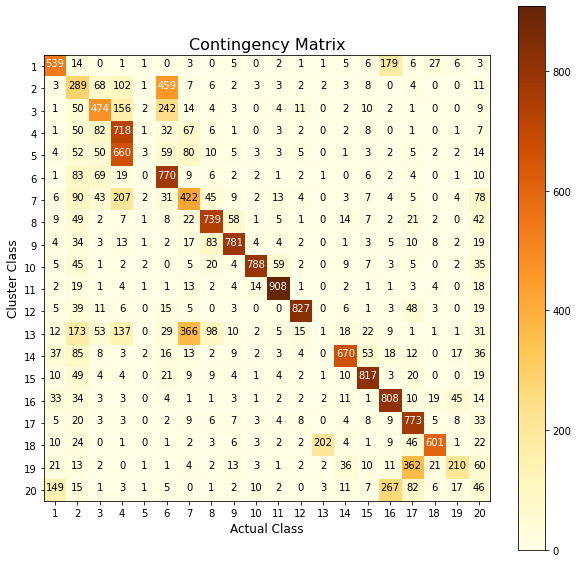

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.560304
Completeness Score: 0.587032
V-Measure Score: 0.573356
Adjusted Rand Index: 0.436063
Adjusted Mutual Information: 0.571935
n_components: 50
UMAP complete after 66.033413 seconds
Finished clustering in 3.591456 seconds
Show Contingency Matrix:


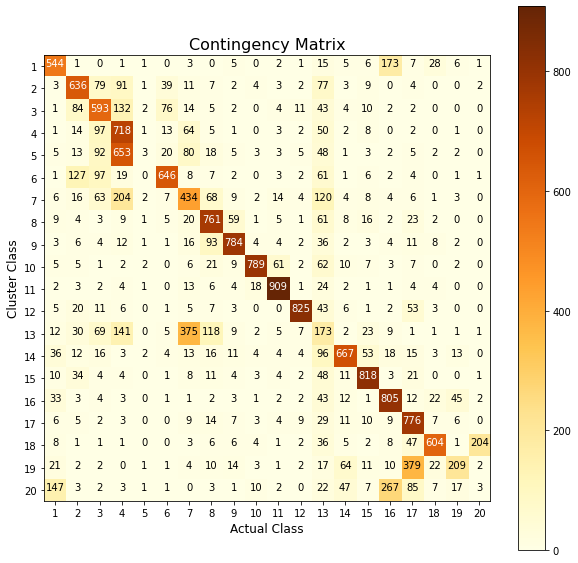

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571971
Completeness Score: 0.595419
V-Measure Score: 0.583459
Adjusted Rand Index: 0.452224
Adjusted Mutual Information: 0.582076
n_components: 100
UMAP complete after 84.936637 seconds
Finished clustering in 5.227653 seconds
Show Contingency Matrix:


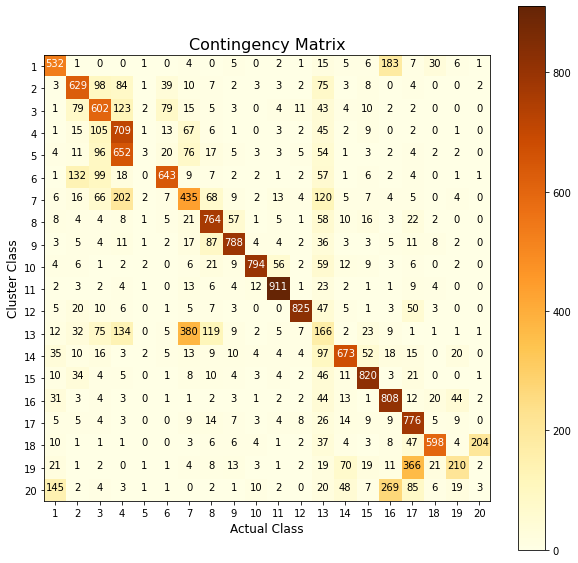

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.572130
Completeness Score: 0.595208
V-Measure Score: 0.583441
Adjusted Rand Index: 0.453238
Adjusted Mutual Information: 0.582058
n_components: 300
UMAP complete after 185.484625 seconds
Finished clustering in 11.690199 seconds
Show Contingency Matrix:


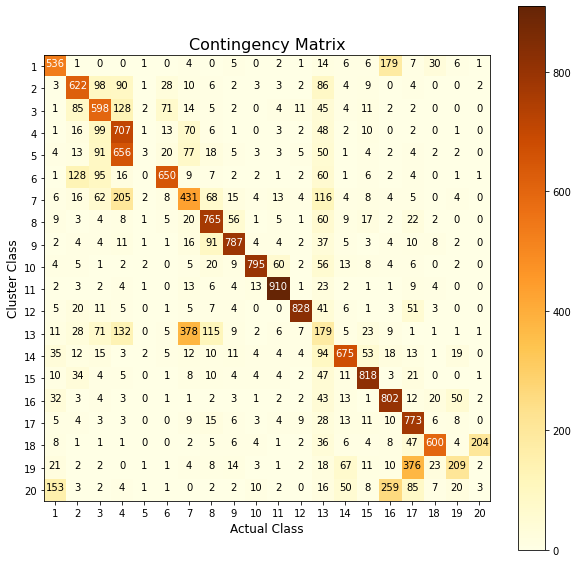

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571842
Completeness Score: 0.594804
V-Measure Score: 0.583097
Adjusted Rand Index: 0.453070
Adjusted Mutual Information: 0.581713


In [19]:
# Question 11
umap_cosine_homogeneity_1ist = []
umap_cosine_completeness_1ist = []
umap_cosine_v_measure_1ist = []
umap_cosine_adjusted_rand_index_1ist = []
umap_cosine_adjusted_mutual_info_1ist = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    umap_dataset, umap = umap_dimension_reduction(X_train_tfidf_20, n_components=r, metric='cosine', disconnection_distance=2, random_state=0)
    k_means, km = k_means_clustering(umap_dataset, y_true_20, n_clusters=20, random_state=0, max_iter=1000, n_init=30)
    umap_cosine_homogeneity_1ist.append(k_means['homogeneity'])
    umap_cosine_completeness_1ist.append(k_means['completeness'])
    umap_cosine_v_measure_1ist.append(k_means['v_measure'])
    umap_cosine_adjusted_rand_index_1ist.append(k_means['adjusted_rand_index'])
    umap_cosine_adjusted_mutual_info_1ist.append(k_means['adjusted_mutual_info'])

<Figure size 432x288 with 0 Axes>

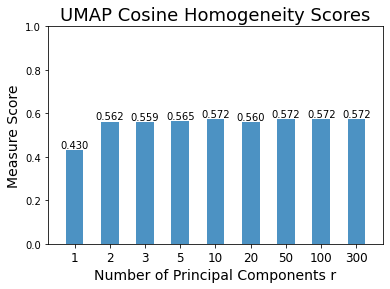

<Figure size 432x288 with 0 Axes>

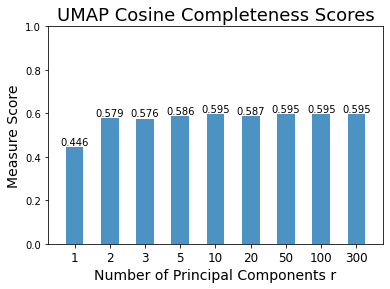

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

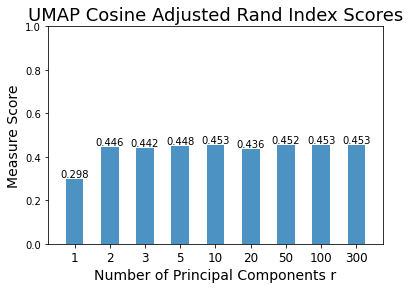

<Figure size 432x288 with 0 Axes>

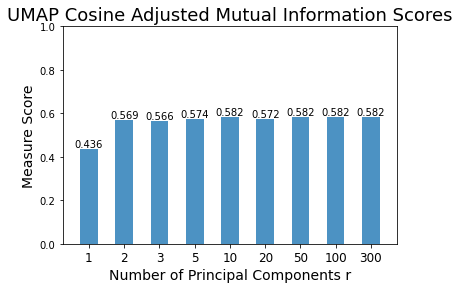

In [20]:
plot_histogram('UMAP Cosine Homogeneity Scores', umap_cosine_homogeneity_1ist)
plot_histogram('UMAP Cosine Completeness Scores', umap_cosine_completeness_1ist)
plot_histogram('UMAP Cosine V-Measure Scores', umap_cosine_v_measure_1ist)
plot_histogram('UMAP Cosine Adjusted Rand Index Scores', umap_cosine_adjusted_rand_index_1ist)
plot_histogram('UMAP Cosine Adjusted Mutual Information Scores', umap_cosine_adjusted_mutual_info_1ist)